In [ ]:
import mlflow
from camelyon.log_ops import TRACKING_URI

mlflow.set_tracking_uri(TRACKING_URI)

#### 1. Annotation coaraseness

In [5]:
import mlflow
import pandas as pd
import seaborn as sns 
from matplotlib import pyplot as plt

rows = list()

for random_state in range(2018, 2027):
    for morphology_value in [448, 896, 1344, 1792, 2240]:
        query_rows = mlflow.search_runs(
            experiment_names=["attention_induction"], 
            filter_string=(
            f"params.learning = 'attention_induction' "
            "AND params.sampling_ratio = '1.0' "
            "AND params._lambda = '1.0' "
            "AND params.threshold = 'None' "
            f"AND params.random_state = '{random_state}'"
            f"AND params.morphology_value = '{morphology_value}'"
            )
        )

        if not query_rows.empty and "metrics.test_auroc" in query_rows.columns:
            rows.append(query_rows)
    
        query_rows = mlflow.search_runs(
            experiment_names=["attention_induction"], 
            filter_string=(
            f"params.learning = 'ltr' "
            "AND params.sampling_ratio = '1.0' "
            "AND params._lambda = '1.0' "
            f"AND params.random_state = '{random_state}'"
            f"AND params.morphology_value = '{morphology_value}'"
            )
        )

        if not query_rows.empty and "metrics.test_auroc" in query_rows.columns:
            rows.append(query_rows)

# References
for random_state in range(2018, 2027):
    query_rows = mlflow.search_runs(
        experiment_names=["attention_induction"], 
        filter_string=(
            f"params.learning = 'ltr' "
            "AND params.sampling_ratio = '1.0' "
            "AND params._lambda = '1.0' "
            f"AND params.random_state = '{random_state}' "
            f"AND params.margin = '1.0' " 
        ) # morphology_value not found d/t already recorded in mlflow
    )
    query_rows = query_rows.loc[query_rows["params.morphology_value"].isna()]
    query_rows["params.morphology_value"] = 0
    rows.append(query_rows)
    
for random_state in range(2018, 2027):
    query_rows = mlflow.search_runs(
        experiment_names=["attention_induction"], 
        filter_string=(
            f"params.learning = 'attention_induction' "
            "AND params.sampling_ratio = '1.0' "
            "AND params._lambda = '1.0' "
            f"AND params.random_state = '{random_state}'"
            "AND params.threshold = 'None' "       
        )
    )
    query_rows = query_rows.loc[query_rows["params.morphology_value"].isna()]
    query_rows["params.morphology_value"] = 0
    rows.append(query_rows)

data = pd.concat(rows)
data_view = data[["metrics.test_auroc", "metrics.test_prauc", "metrics.test_accuracy", "params.morphology_value", "params.learning"]]


In [6]:
# Rename
learning_strategy_map = {
    "base": "Base(AB-MIL)", 
    "attention_induction": "Attention Induction", 
    "ltr": "Rank Induction"
}
data_view['params.learning'] = data_view['params.learning'].map(learning_strategy_map)
data_view["params.morphology_value"] = data_view["params.morphology_value"].astype(int)

df_melted = data_view.melt(id_vars=["params.learning", "params.morphology_value"], var_name="metric", value_name="value")
df_melted["metric"] = df_melted["metric"].str.replace("metrics.", "", regex=False)
df_melted["metric"] = df_melted["metric"].replace({
    "test_auroc": "AUROC", 
    "test_prauc": "AUPRC", 
    "test_accuracy": "Accuracy"
})

/tmp/ipykernel_1123950/128524321.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_view['params.learning'] = data_view['params.learning'].map(learning_strategy_map)
/tmp/ipykernel_1123950/128524321.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_view["params.morphology_value"] = data_view["params.morphology_value"].astype(int)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

# 기본 그래프
fig, axes = plt.subplots(figsize=(9, 5))

sns.pointplot(
    data=df_melted.loc[
        (df_melted["metric"] == "AUROC") & 
        (df_melted["params.learning"] == "Rank Induction")
    ], 
    x="params.morphology_value", 
    y="value", 
    hue="params.learning",
    ax=axes
)

axes.set_ylim(0.60, 0.92)
axes.set_xlabel("Annotation padding (/px in 40x)")
axes.set_ylabel("AUROC")
axes.legend_.remove()
# axes.legend(loc='lower right')

# 4. 플롯을 위로 올려서 하단 여백 확보
fig.subplots_adjust(bottom=0.10)  # 하단 여백을 30% 확보 (0~1 비율)

# 저장 시 여백 확보
plt.savefig("results/0_graphical_abstract_auroc_rank_induction.png", dpi=300, bbox_inches='tight', transparent=True)


#### B-2. Data scarcity

In [ ]:
import seaborn as sns
import pandas as pd

learning_types = ['base', 'attention_induction', 'ltr']
random_states = ['2023', '2024', '2025', '2026', '2027']

all_rows = []
for learning in learning_types:
    for random_state in random_states:
        rows = mlflow.search_runs(
            experiment_names=["attention_induction"],
            filter_string=(
                f"params.learning = '{learning}' "
                f"and params.random_state = '{random_state}' "
                f"AND params.margin = '1.0' "
            )
        )
        if "params.morphology_value" in rows.columns:
            rows = rows[(rows["params.morphology_value"].isna() & rows["params.dataset"].isna())]
        else:
            rows = rows
        all_rows.append(rows)


# 모든 결과를 하나의 DataFrame으로 합치기
data = pd.concat(all_rows).reset_index(drop=True)
data["params.sampling_ratio"] = data["params.sampling_ratio"].astype(float)
data_view = data[["metrics.test_auroc", "metrics.test_prauc", "params.learning", "params.sampling_ratio"]]

# rename
data_view["params.learning"] = data_view["params.learning"].replace({"base":"AB-MIL", "attention_induction": "Attention induction", "ltr":"Rank induction"})

In [ ]:
from matplotlib import pyplot as plt
from statannot import add_stat_annotation

fig, ax = plt.subplots(figsize=(6, 4))
sns.pointplot(data=data_view, x="params.sampling_ratio", y="metrics.test_auroc", hue="params.learning")
ax.set_xlabel("Sampling Ratio (Fraction of Training Data Used)")
ax.set_ylabel("AUROC")
ax.legend(loc="lower right")

sorted_ratios = sorted(data_view["params.sampling_ratio"].unique())
ax.set_xticklabels([f"{int(r * 100)}%" for r in sorted_ratios])

plt.savefig("results/0_data_scarcity.png", dpi=300, bbox_inches='tight', transparent=True)


#### C-1. Camelyon16 tumor detection performance

In [1]:
import mlflow
from camelyon.log_ops import TRACKING_URI
mlflow.set_tracking_uri(TRACKING_URI)


import seaborn as sns
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
from statannot import add_stat_annotation

base_rows = mlflow.search_runs(
    experiment_names=["attention_induction"], 
    filter_string=(
        "params.learning = 'base' "
        "AND params.sampling_ratio = '1.0' "
        # "AND params.morphology_value = 'None'"
    )
)
att_rows = mlflow.search_runs(
    experiment_names=["attention_induction"], 
    filter_string=(
        "params.learning = 'attention_induction' "
        "AND params.sampling_ratio = '1.0' "
        "AND params._lambda = '1.0' "
        "AND params.threshold = 'None' "
        # "AND params.morphology_value = 'None'"
    )
)
ltr_rows = mlflow.search_runs(
    experiment_names=["attention_induction"], 
    filter_string=(
        "params.learning = 'ltr' "
        "AND params.sampling_ratio = '1.0' "
        "AND params._lambda = '1.0' "
        "AND params.threshold = '1.0' "
        # "AND params.morphology_value = 'None' "
    )
)
data = pd.concat([base_rows, att_rows, ltr_rows])
data = data.loc[data["params.morphology_value"].isna()]

learning_strategy_map = {
    "base": "Base", 
    "attention_induction": "Attention Induction", 
    "ltr": "Rank Induction"
}
data['params.learning'] = data['params.learning'].map(learning_strategy_map)
data = data.reset_index(drop=True)

In [2]:
from collections import defaultdict

import torch
import tqdm
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve, roc_auc_score
import torch.multiprocessing as mp

from camelyon.datasets import MILDataset

mp.set_start_method("spawn")

test_dataset = MILDataset(root_dir="/vast/AI_team/dataset/CAMELYON16/feature/resnet50_3rd_20x_h5/test")
test_dataloader = DataLoader(test_dataset, shuffle=False, prefetch_factor=4, num_workers=8)

@torch.no_grad()
def forward(model, device, dataloader) -> dict:
    res = list()
    for i, batch in tqdm.tqdm(enumerate(dataloader), total=len(dataloader)):
        x, y = batch
        x = x.to("cuda")
        y = y.cpu().detach().item()
        
        logits, att_wt = model(x)
        prediction = {
            "label": y,
            "confidence": torch.sigmoid(logits).item()
        }        
        res.append(prediction)
        
    return res

all_results = defaultdict(list)
for i, row in data.iterrows():
    run_id = row["run_id"]
    method = row["params.learning"]
    fold = i
    
    model = mlflow.pytorch.load_model(f"file:///vast/AI_team/mlflow_artifact/25/{run_id}/artifacts/model").eval().to("cuda")
    model.threshold = None if method != "Rank Induction" else 1.0
    preds = forward(model, "cuda", test_dataloader)
    for pred in preds:
        all_results["fold"].append(fold)
        all_results["method"].append(method)
        all_results["label"].append(pred["label"])
        all_results["confidence"].append(pred["confidence"])

/home/heon/anaconda3/envs/camelyon/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 129/129 [02:58<00:00,  1.38s/it]


In [3]:
results_df = pd.DataFrame(all_results)

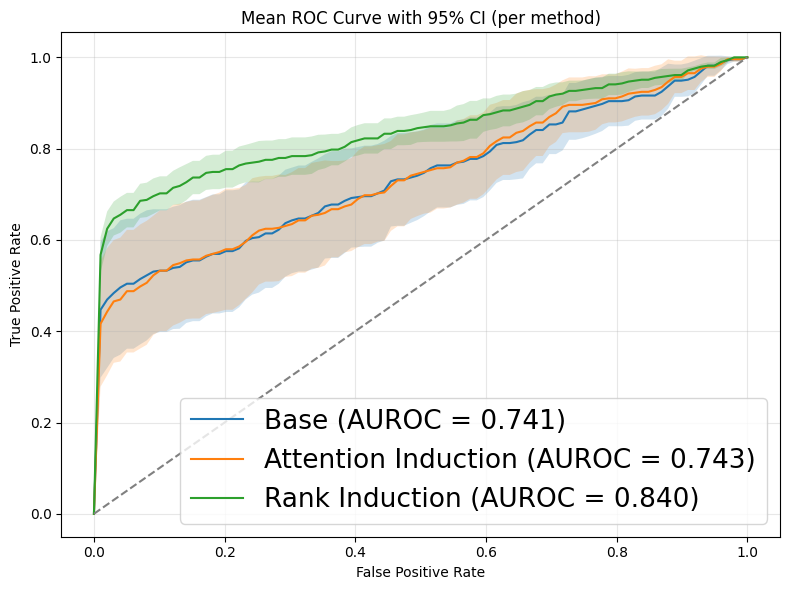

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy import interp
from scipy.stats import sem

methods = results_df["method"].unique()
folds = results_df["fold"].unique()

# 공통 FPR 축 생성
mean_fpr = np.linspace(0, 1, 100)

plot_data = {}

for method in methods:
    tprs = []
    aucs = []

    for fold in folds:
        df = results_df[(results_df["method"] == method) & (results_df["fold"] == fold)]
        if df["label"].nunique() < 2:
            continue

        fpr, tpr, _ = roc_curve(df["label"], df["confidence"])
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0  # FPR=0일 때 TPR도 0으로
        tprs.append(interp_tpr)
        aucs.append(auc(fpr, tpr))

    if tprs:
        tprs = np.array(tprs)
        mean_tpr = np.mean(tprs, axis=0)
        std_tpr = np.std(tprs, axis=0)
        ci = sem(tprs, axis=0) * 1.96  # 95% CI

        plot_data[method] = {
            "mean_tpr": mean_tpr,
            "ci": ci,
            "mean_auc": np.mean(aucs),
            "std_auc": np.std(aucs),
        }

plt.figure(figsize=(8, 6))

for method, data in plot_data.items():
    mean_tpr = data["mean_tpr"]
    ci = data["ci"]
    mean_auc = data["mean_auc"]

    plt.plot(mean_fpr, mean_tpr, label=f"{method} (AUROC = {mean_auc:.3f})")
    plt.fill_between(mean_fpr, mean_tpr - ci, mean_tpr + ci, alpha=0.2)

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Mean ROC Curve with 95% CI (per method)")
plt.legend(loc="lower right", fontsize=19)
plt.grid(alpha=0.3)
plt.tight_layout()

plt.savefig("results/0_camelyon_auc.png", dpi=300, bbox_inches='tight', transparent=True)



In [7]:
import mlflow
from camelyon.log_ops import TRACKING_URI

mlflow.set_tracking_uri(TRACKING_URI)

data = mlflow.search_runs(
    experiment_names=["attention_induction"], 
    filter_string=("params.data_dir = '/vast/AI_team/dataset/DigestPath2019/task2_classification/feature/resnet50_custom_224'")
)
data = data.loc[~data["params.learning"].isna()]

In [12]:

import os
from collections import defaultdict

import torch
import tqdm
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve, roc_auc_score
import torch.multiprocessing as mp

from camelyon.datasets import DigestPathAttentionInductionDataset

# mp.set_start_method("spawn")

test_dataset = DigestPathAttentionInductionDataset(
    root_dir=os.path.join("/vast/AI_team/dataset/DigestPath2019/task2_classification/feature/resnet50_custom_224", "test"),
    slide_dir = os.path.join("/vast/AI_team/dataset/DigestPath2019/task2_classification/slide", "test"),
    annotation_dir = os.path.join("/vast/AI_team/dataset/DigestPath2019/task2_classification", "annotations"),
    image_dir = os.path.join("/vast/AI_team/dataset/DigestPath2019/task2_classification/patch/224", "test"),
)
test_dataloader = DataLoader(test_dataset, shuffle=False, prefetch_factor=4, num_workers=8)

@torch.no_grad()
def forward(model, device, dataloader) -> dict:
    res = list()
    for i, batch in tqdm.tqdm(enumerate(dataloader), total=len(dataloader)):
        x, y, patch_label = batch
        x = x.to("cuda")
        y = y.cpu().detach().item()
        
        logits, att_wt = model(x)
        prediction = {
            "label": y,
            "confidence": torch.sigmoid(logits).item()
        }        
        res.append(prediction)
        
    return res

all_results = defaultdict(list)
for i, row in data.iterrows():
    run_id = row["run_id"]
    method = row["params.learning"]
    fold = i
    
    model = mlflow.pytorch.load_model(f"file:///vast/AI_team/mlflow_artifact/25/{run_id}/artifacts/model").eval().to("cuda")
    model.threshold = None if method != "Rank Induction" else 1.0
    preds = forward(model, "cuda", test_dataloader)
    for pred in preds:
        all_results["fold"].append(fold)
        all_results["method"].append(method)
        all_results["label"].append(pred["label"])
        all_results["confidence"].append(pred["confidence"])

 98%|█████████▊| 130/132 [00:08<00:00, 26.10it/s][W CudaIPCTypes.cpp:16] Producer process has been terminated before all shared CUDA tensors released. See Note [Sharing CUDA tensors]
[W CudaIPCTypes.cpp:16] Producer process has been terminated before all shared CUDA tensors released. See Note [Sharing CUDA tensors]
 98%|█████████▊| 130/132 [00:08<00:00, 24.19it/s][W CudaIPCTypes.cpp:16] Producer process has been terminated before all shared CUDA tensors released. See Note [Sharing CUDA tensors]
[W CudaIPCTypes.cpp:16] Producer process has been terminated before all shared CUDA tensors released. See Note [Sharing CUDA tensors]
 92%|█████████▏| 122/132 [00:07<00:00, 19.82it/s][W CudaIPCTypes.cpp:16] Producer process has been terminated before all shared CUDA tensors released. See Note [Sharing CUDA tensors]
[W CudaIPCTypes.cpp:16] Producer process has been terminated before all shared CUDA tensors released. See Note [Sharing CUDA tensors]
 98%|█████████▊| 130/132 [00:09<00:00, 21.54it/s]

In [13]:
import pandas as pd
results_df = pd.DataFrame(all_results)

In [20]:
df

,fold,method,label,confidence


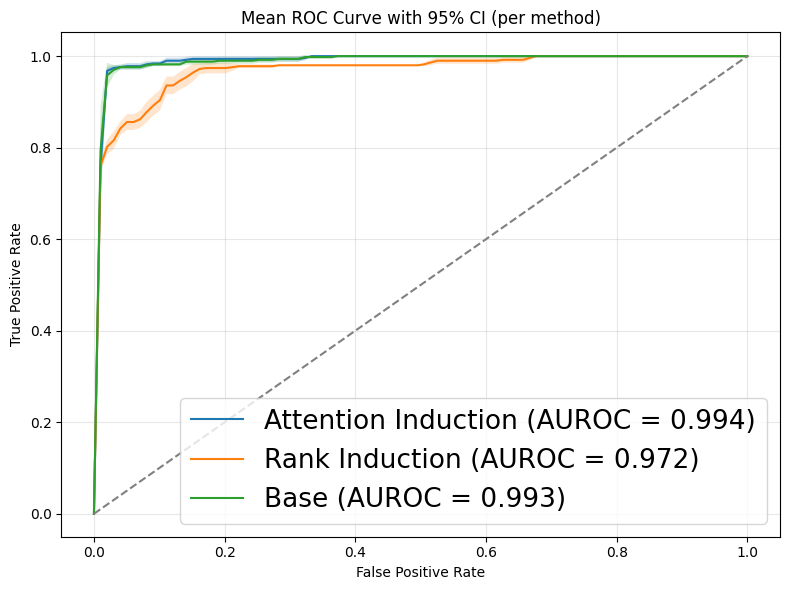

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy import interp
from scipy.stats import sem


learning_strategy_map = {
    "base": "Base", 
    "attention_induction": "Attention Induction", 
    "ltr": "Rank Induction"
}
methods = results_df["method"].unique()
folds = results_df["fold"].unique()

# 공통 FPR 축 생성
mean_fpr = np.linspace(0, 1, 100)

plot_data = {}

for method in methods:
    tprs = []
    aucs = []

    for fold in folds:
        df = results_df[(results_df["method"] == method) & (results_df["fold"] == fold)]
        if df["label"].nunique() < 2:
            continue

        fpr, tpr, _ = roc_curve(df["label"], df["confidence"])
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0  # FPR=0일 때 TPR도 0으로
        tprs.append(interp_tpr)
        aucs.append(auc(fpr, tpr))

    if tprs:
        tprs = np.array(tprs)
        mean_tpr = np.mean(tprs, axis=0)
        std_tpr = np.std(tprs, axis=0)
        ci = sem(tprs, axis=0) * 1.96  # 95% CI

        plot_data[method] = {
            "mean_tpr": mean_tpr,
            "ci": ci,
            "mean_auc": np.mean(aucs),
            "std_auc": np.std(aucs),
        }

plt.figure(figsize=(8, 6))

for method, data in plot_data.items():
    mean_tpr = data["mean_tpr"]
    ci = data["ci"]
    mean_auc = data["mean_auc"]

    plt.plot(mean_fpr, mean_tpr, label=f"{learning_strategy_map[method]} (AUROC = {mean_auc:.3f})")
    plt.fill_between(mean_fpr, mean_tpr - ci, mean_tpr + ci, alpha=0.2)

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Mean ROC Curve with 95% CI (per method)")
plt.legend(loc="lower right", fontsize=19)
plt.grid(alpha=0.3)
plt.tight_layout()

plt.savefig("results/0_digestPath.png", dpi=300, bbox_inches='tight', transparent=True)